##  pretrained models in PyTorch

This notebook only has the default pyTorch models

- VGG and VGG BN 
- We only want the initial Conv layers since we know how the  larger layers behave

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn

import pandas as pd

import numpy as np
import powerlaw

from tqdm import tqdm_notebook as tqdm

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,5]
matplotlib.rcParams.update({'font.size': 16})

In [3]:
MIN_DIM = 50

### All Linear Models

In [4]:
def get_conv2D_Wmats(Wtensor):
    """Extract W slices from a 4 index conv2D tensor of shape: (N,M,i,j) or (M,N,i,j).  Return ij (N x M) matrices"""
    Wmats = []
    s = Wtensor.shape
    N, M, imax, jmax = s[0],s[1],s[2],s[3]
    #print("tensor shape", N,M,imax,jmax)
    for i in range(imax):
        for j in range(jmax):
            W = Wtensor[:,:,i,j]
            if N < M:
                W = W.T
            Wmats.append(W)
    return Wmats

In [5]:
def count_layers(model):
    """Loops over a pytorch model and counts all the weight matrices, linear, conv2d, and conv2d-slices"""
    num_linear, num_conv2d, num_conv2d_slices = 0, 0, 0
    
    for im, m in enumerate(model.modules()):
        #print(im,m)
        if isinstance(m, nn.Linear):    
            #print("linear")
            W = np.array(m.weight.data.clone().cpu())
            if W is not None:
                #print(im,m, W.shape)
                num_linear += 1
        elif isinstance(m, nn.Conv2d):
            #print("conv2d")
            Wtensor = np.array(m.weight.data.clone().cpu())
            #print(Wtensor.shape)
            Wmats = get_conv2D_Wmats(Wtensor)
            #print(im,m)
            num_conv2d += 1
            for W in Wmats:
                #print(W.shape)
                if (np.min(W.shape) >= MIN_DIM):
                    num_conv2d_slices += 1
                
    return num_linear, num_conv2d, num_conv2d_slices
        

In [6]:
def iter_pytotch_layers(model, min_dim=MIN_DIM):
    """Iterate over a pytorch layers and  weight matrix.  
    Supports linear, conv2d, and conv2d-slices"""
    for im, m in enumerate(model.modules()):
        if isinstance(m, nn.Linear):     
            W = np.array(m.weight.data.clone().cpu())
            if W is not None:
                yield W
        elif isinstance(m, nn.Conv2d):
            Wtensor = np.array(m.weight.data.clone().cpu())
            Wmats = get_conv2D_Wmats(Wtensor)
            for W in Wmats:
                if (np.min(W.shape) >= min_dim):
                    yield W

In [66]:
def calc_model_alphas(model):
    try:
        alphas, logNorm2s, lmaxs, Ms = [], [], [], []

        for W in tqdm(iter_pytotch_layers(model)):
            M, N = np.min(W.shape), np.max(W.shape)
            print(M,N)
            if M > 1024:
                break
                
            X=np.dot(W.T,W)#/N
            evals = np.linalg.eigvals(X)

            l_max, l_min = np.max(evals), np.min(evals)
        
            fit = powerlaw.Fit(evals, xmax=l_max, verbose=False)
            alphas.append(fit.alpha)
            
            print(N, M, fit.alpha, np.max(evals), fit.D)

            lmaxs.append(l_max)
            
            logNorm2 = 2*np.log10(np.linalg.norm(W))
            logNorm2s.append(logNorm2)
            
            Ms.append(M)
            
           
    except Exception as e: 

        print("skipping ", model_name)
        print(e)

        pass
    
    return  alphas,  logNorm2s, lmaxs, Ms

In [67]:

alphas, logNorm2s, lmaxs, Ms= {}, {}, {}, {}


model_name = 'vgg11'
model = models.vgg11(pretrained=True)
alphas[model_name], logNorm2s[model_name], lmaxs[model_name], Ms[model_name]  =  calc_model_alphas(model)


model_name = 'vgg13'
model = models.vgg13(pretrained=True)
alphas[model_name], logNorm2s[model_name], lmaxs[model_name], Ms[model_name]  =  calc_model_alphas(model)


model_name = 'vgg16'
model = models.vgg16(pretrained=True)
alphas[model_name], logNorm2s[model_name], lmaxs[model_name], Ms[model_name]  =  calc_model_alphas(model)

model_name = 'vgg19'
model = models.vgg19(pretrained=True)
alphas[model_name], logNorm2s[model_name], lmaxs[model_name], Ms[model_name]  =  calc_model_alphas(model)





64 128
128 64 1.650137927685248 4.4921966 0.16948550674140528
64 128
128 64 1.5729747877925546 5.514614 0.17973865488686586
64 128


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


128 64 1.4121039154274824 4.306559 0.19428092329903363
64 128
128 64 1.4345914630705163 4.5565233 0.1813392893398612
64 128
128 64 1.6184990207993288 9.214569 0.1623258392548097
64 128
128 64 1.3854852767997903 5.387079 0.18905146951963192
64 128
128 64 1.5692040991757101 3.76813 0.1819834054960493
64 128
128 64 1.4466119923786733 4.968327 0.1815802550421065
64 128
128 64 1.6136188576939716 4.180959 0.17297129522923904
128 256
256 128 2.682210846422947 2.5955484 0.1583916578081227
128 256
256 128 1.6245755726082531 4.0391965 0.1503834258303519
128 256
256 128 1.7481680076336596 2.5432076 0.15976226966949958
128 256
256 128 2.5760767204495743 4.3783197 0.13313311049252113
128 256
256 128 2.5337265435884815 7.667854 0.12604021306471358
128 256
256 128 1.6150831744688707 4.615691 0.12912548885033093
128 256
256 128 1.6649287476739605 2.4112122 0.1549378574611492
128 256
256 128 1.6911654469954596 4.0136957 0.13113802739788333
128 256
256 128 2.050366450160216 2.617932 0.14425818767317655


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1160: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


256 256 1.9744266962582193 3.1301107 0.12141224975225917
256 256
256 256 2.0731954449837686 2.4406357 0.13215305437051822
256 512
512 256 2.6517233142465617 2.9787853 0.10811343583529665
256 512
512 256 2.1681145787476686 3.6407948 0.12371983162707578
256 512
512 256 2.6890827915766193 2.9929526 0.0997551251811657
256 512
512 256 2.055719195313354 4.1068416 0.11025214784748127
256 512
512 256 3.8241502645593726 7.136063 0.09906478191522528
256 512
512 256 2.84166117542272 4.057766 0.10146023500780976
256 512
512 256 2.5426596845943683 2.9451003 0.11033068789904138
256 512
512 256 2.899488537624586 3.6590335 0.11620857091223558
256 512
512 256 2.267162188123911 3.0900106 0.11398757505084495
512 512
512 512 3.1496479736823915 4.4045234 0.0512106071091904
512 512
512 512 3.517971604429102 5.955502 0.06635110385231391
512 512
512 512 3.1470364265948705 4.2881646 0.05371105570443063
512 512
512 512 2.7469938895003425 6.009544 0.057415075890339784
512 512
512 512 2.4074220155135437 9.346973 

64 64
64 64 1.9985713827481764 1.8433783 0.18598422318374896
64 64
64 64 1.5227657731389206 2.8955903 0.1591835995761306
64 64
64 64 2.1369653116340657 1.989064 0.1649180219111489
64 64
64 64 1.4775757344538796 2.806978 0.16073576349864094
64 64
64 64 1.5488981522700196 3.6493487 0.14938147695394788
64 64
64 64 1.552251593519485 2.5130134 0.1676522857235614
64 64
64 64 1.4229919416176215 1.9675564 0.1955324420542982
64 64
64 64 1.487041377781069 2.9315708 0.16496920667762738
64 64
64 64 1.4267630969519396 1.8302585 0.20325863753127849
64 128
128 64 1.8107387972834963 2.7411118 0.14500309093003794
64 128
128 64 1.7729935290641499 3.8832583 0.14534383193217193
64 128
128 64 1.8114717090050756 2.7855337 0.1576243470575801
64 128
128 64 1.7804247325978086 3.2689245 0.15575126226931185
64 128
128 64 1.7223669436311277 5.5365415 0.143150337404792
64 128
128 64 1.7330245624125047 3.3551154 0.14202297590837776
64 128
128 64 1.8129091016382137 3.7301686 0.13809808163665127
64 128
128 64 1.75914

64 64
64 64 3.142419288285629 2.135813 0.15201190098773232
64 64
64 64 2.692689402734075 3.4032743 0.1534784511257814
64 64
64 64 1.7915682324948934 2.1713915 0.18345626221429012
64 64
64 64 2.6447134454421075 3.38234 0.137344189134802
64 64
64 64 2.8553843635911287 4.4910364 0.1428571428571429
64 64
64 64 1.5722767200278125 2.9965973 0.15895587392628097
64 64
64 64 1.559346673791191 1.7237109 0.17842343582856846
64 64
64 64 2.38329341854676 3.5007148 0.13852603672086383
64 64
64 64 3.1091397611473846 1.9091358 0.17602566012463788
64 128
128 64 1.7198476730371377 2.3325818 0.1549027594845256
64 128
128 64 1.6920181545898179 2.5221329 0.15375671289594117
64 128
128 64 1.8732094529508143 2.383183 0.14726968944247554
64 128
128 64 1.645437705877346 3.0940754 0.15652976099798088
64 128
128 64 1.6638425358960478 5.161492 0.14086586596920753
64 128
128 64 1.7355898323596317 2.7422535 0.14747562472590364
64 128
128 64 1.9029351985215857 2.2734969 0.15153521645309664
64 128
128 64 1.6830606681

64 64
64 64 1.4433520831118654 1.8160152 0.18909780242370278
64 64
64 64 1.5280308884955578 2.4917834 0.17109562690171054
64 64
64 64 2.1337335167810094 1.7829849 0.19530536960122558
64 64
64 64 1.517589126003378 2.3594978 0.17687643999405522
64 64
64 64 1.5564283041018394 3.7638555 0.1654894029266436
64 64
64 64 1.4913515429949764 2.7858684 0.15060937621610793
64 64
64 64 1.459625324051018 1.4963005 0.19951915024596234
64 64
64 64 1.5392097730381593 2.7609317 0.17159471094849066
64 64
64 64 1.4579005294559422 1.9795327 0.17514124022793398
64 128
128 64 1.9480243489820377 2.312067 0.1321752598871735
64 128
128 64 1.7655845606120806 2.8761241 0.15214293731160344
64 128
128 64 1.7468504015853135 2.3741572 0.16942892371357599
64 128
128 64 1.786098414500827 2.5788352 0.15315540422805196
64 128
128 64 1.787802757064858 5.3750014 0.14205520217926493
64 128
128 64 1.7338402078189068 2.9869635 0.14496542877469065
64 128
128 64 1.6244489656829013 2.2078998 0.16858057869919807
64 128
128 64 1.7

512 512 4.463597001482109 3.8903544 0.06780881808309636
512 512
512 512 3.0278515462943894 4.1721854 0.06558411275970277
512 512
512 512 4.379189468504535 3.5975144 0.05880948441861911
512 512
512 512 3.9845180909514823 4.3286467 0.06291787140328226
512 512
512 512 4.129110514758372 4.2454424 0.053583434963623
512 512
512 512 4.279777931930042 3.7919886 0.04945635536761073
4096 25088


In [68]:
def plot_alpha_lognorm(alphas, logNorm2s, lmaxs, title=""):
    for model_name in alphas:
        log_nrm = np.array(logNorm2s[model_name])
        log_lmax = np.log10(np.array(lmaxs[model_name]))
        alpha = np.array(alphas[model_name])

        plt.scatter(alpha, log_nrm, label=model_name)
        
    plt.legend()
    plt.title(title+r" $\alpha$ vs $\log\Vert\mathbf{W}\Vert$")
    plt.xlabel(r"$\alpha$")
    plt.ylabel(r"$\log\Vert\mathbf{W}\Vert$")
    plt.show()

In [69]:
def plot_each_alpha_lognorm(alphas, logNorm2s, lmaxs, title=""):
    for model_name in alphas:
        log_nrm = np.array(logNorm2s[model_name])
        log_lmax = np.log10(np.array(lmaxs[model_name]))
        alpha = np.array(alphas[model_name])

        plt.scatter(alpha, log_nrm, label=model_name)
        
        plt.legend()
        plt.title(title+r" $\alpha$ vs $\log\Vert\mathbf{W}\Vert^{2}$")
        plt.xlabel(r"$\alpha$")
        plt.ylabel(r"$\log\Vert\mathbf{W}\Vert$")
        plt.show()

In [70]:
def plot_all_alpha_lognorms(alphas, logNorm2s, lmaxs, title=""):
    all_log_nrms, all_log_lmaxs, all_alphas = [], [], []
    for model_name in alphas:
        all_log_nrms.extend(np.array(logNorm2s[model_name]))
        all_log_lmaxs.extend(np.log10(np.array(lmaxs[model_name])))
        all_alphas.extend(np.array(alphas[model_name]))

    plt.scatter(all_alphas, all_log_nrms)
    plt.legend()
    plt.title(title+r" $\alpha$ vs $\log\Vert\mathbf{W}\Vert^{2}$")
    plt.xlabel("alpha")
    plt.ylabel("log lmax ")
    plt.show()

In [12]:
def plot_averages(alphas, logNorm2s, title="ResNet Models"):
    x = np.arange(len(alphas))
    avg_alphas = [np.average(alphas[model_name]) for model_name in alphas.keys()]
    avg_lognorms = [np.average(logNorm2s[model_name]) for model_name in alphas.keys()]      
    plt.scatter(x,avg_alphas, color='red', label='alphas')
    plt.scatter(x,avg_lognorms, color='blue', label='log Norms')
    plt.title(title)
    plt.legend()
    plt.show()

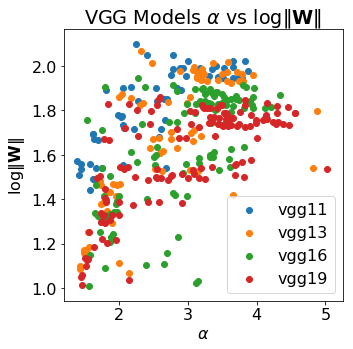

No handles with labels found to put in legend.


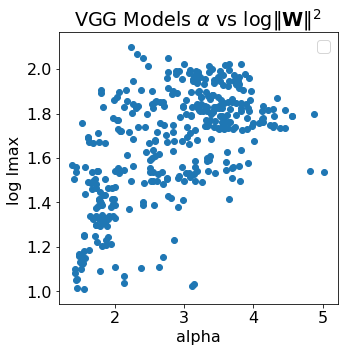

In [13]:
plot_alpha_lognorm(alphas, logNorm2s, lmaxs, title="VGG Models")
plot_all_alpha_lognorms(alphas, logNorm2s, lmaxs,  title="VGG Models")

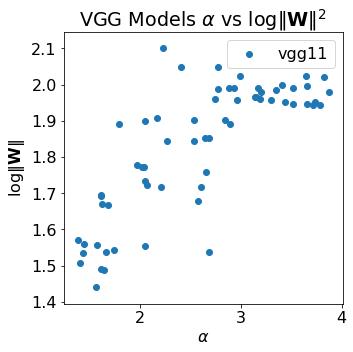

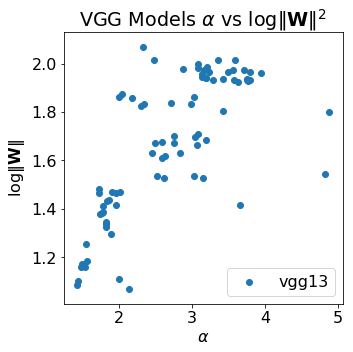

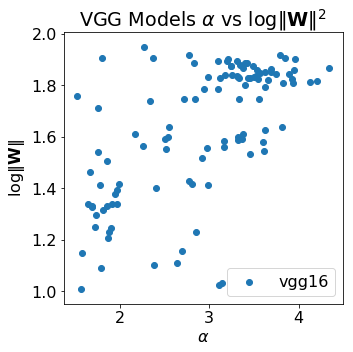

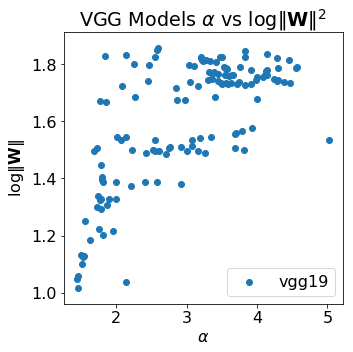

In [14]:
plot_each_alpha_lognorm(alphas, logNorm2s, lmaxs, title="VGG Models")


### VGG13 is the easiest to analyze first

In [15]:
plt.rcParams['figure.figsize'] = [5,5]
    
def plot_each_alpha_relation(alphas, logNorm2s, lmaxs, title=""):
    for model_name in alphas:
        log_nrm = np.array(logNorm2s[model_name])
        log_lmax = np.log10(np.array(lmaxs[model_name]))
        alpha = np.array(alphas[model_name])
        plt.scatter(alpha*log_lmax, log_nrm, label=model_name)
        plt.title(model_name+r": $\alpha\;\log\;\lambda_{max}$ vs $\log\;\Vert\mathbf{W}\Vert^{2}$")
        plt.legend()
        plt.show()

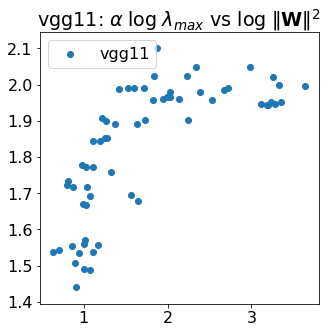

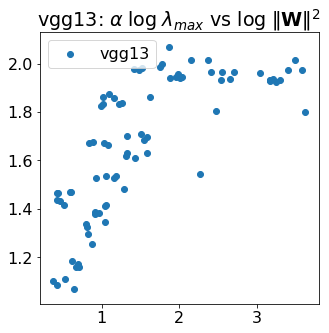

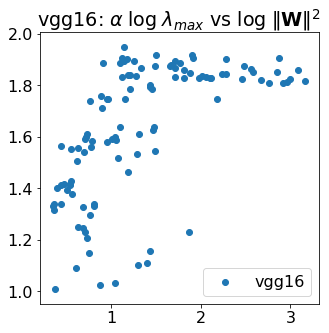

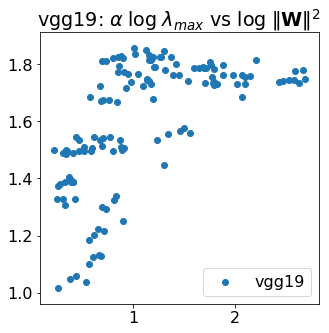

In [16]:
plot_each_alpha_relation(alphas, logNorm2s, lmaxs, title="")

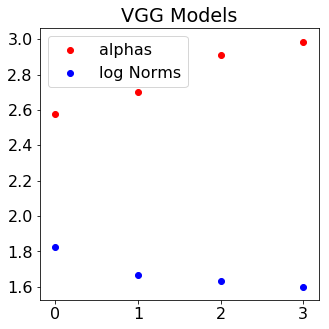

In [17]:
plot_averages(alphas, logNorm2s, title="VGG Models")

### TODO:

- save the eigenvalues to json

array([ 64, 128, 256, 512])

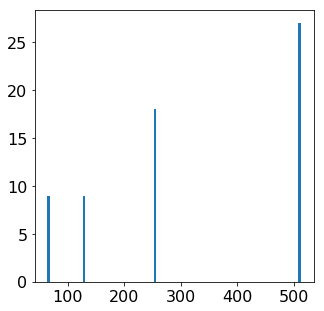

In [30]:
plt.hist(Ms['vgg11'],bins=100);
np.unique( Ms['vgg11'] )

In [50]:
def plot_weighted_averages(alphas, logNorm2s, Ms, lmaxs, title="ResNet Models"):
    x = np.arange(len(alphas))

    avg_alphas = [np.average(np.array(alphas[model_name])*np.log10(np.array(lmaxs[model_name]))) for model_name in alphas.keys()]
    avg_lognorms = [np.average(logNorm2s[model_name]) for model_name in alphas.keys()]      
    plt.scatter(x,avg_alphas, color='red', label='alphas')
    plt.scatter(x,avg_lognorms, color='blue', label='log Norms')
    plt.title(title+": Weighted Averages")
    plt.legend()
    plt.show()

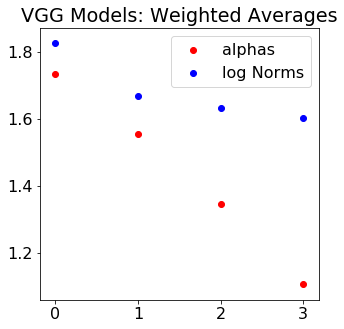

In [51]:
plot_weighted_averages(alphas, logNorm2s, Ms, lmaxs, title="VGG Models")

In [ ]:
def plot_weighgted_alpha(alphas, lmaxs, title=""):
    idx = 0
    for model_name in alphas:
        log_lmax = np.log10(np.array(lmaxs[model_name]))
        alpha = np.array(alphas[model_name])
        w_avg = np.average(alpha*log_lmax)
        plt.scatter( idx ,w_avg , label=model_name)
        idx+=1
    plt.title(title+r": $\alpha\;\log\;\lambda_{max}$")
    plt.legend()
    plt.show()

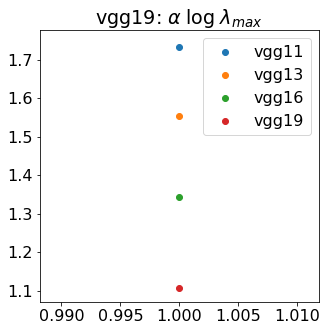

In [65]:
plot_weighgted_alpha(alphas, lmaxs, title="VGG Models")

In [71]:

   
model_name = 'vgg11_bn'
model = models.vgg11_bn(pretrained=True)
alphas[model_name], logNorm2s[model_name], lmaxs[model_name], Ms[model_name]  =  calc_model_alphas(model)



model_name = 'vgg13_bn'
model = models.vgg13_bn(pretrained=True)
alphas[model_name], logNorm2s[model_name], lmaxs[model_name], Ms[model_name]  =  calc_model_alphas(model)


model_name = 'vgg16_bn'
model = models.vgg16_bn(pretrained=True)
alphas[model_name], logNorm2s[model_name], lmaxs[model_name], Ms[model_name]  =  calc_model_alphas(model)


model_name = 'vgg19_bn'
model = models.vgg19_bn(pretrained=True)
alphas[model_name], logNorm2s[model_name], lmaxs[model_name], Ms[model_name]  =  calc_model_alphas(model)


64 128
128 64 1.6496953917188004 2.2935586 0.20626964217109067
64 128


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


128 64 1.5135119106728785 3.4098783 0.23009815101339437
64 128
128 64 1.665327707646311 2.2851653 0.2209023998099248
64 128
128 64 1.7353058272445745 3.6746838 0.2266492047051517
64 128
128 64 1.3312676311713982 5.9175186 0.23262003713385698
64 128
128 64 1.3956648032744803 2.9658542 0.24556426101250384
64 128
128 64 1.7195692353567964 2.4346864 0.18926267029352545
64 128
128 64 1.8362425430432399 3.6271133 0.22276695251794476
64 128
128 64 2.1316335516293248 2.3174334 0.24408105515592438
128 256
256 128 2.238046374616075 2.8390114 0.10909775062339688
128 256
256 128 1.7563879164268874 3.0054948 0.13504896222751206
128 256
256 128 2.2298326819573147 2.985893 0.09628641030015295
128 256
256 128 1.97453682155639 2.9209712 0.13720149067395093
128 256
256 128 2.8687635177255473 5.077884 0.11077822997280629
128 256
256 128 1.6140789346033388 2.738147 0.1406624985093139
128 256
256 128 2.024799479310988 2.6423762 0.11699075769060352
128 256
256 128 1.9798942862284452 2.9642003 0.128844427667

/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:1160: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:701: RuntimeWarning: overflow encountered in double_scalars
  )[1:]


256 256 2.109952901445933 1.496708 0.14019926031127783
256 256
256 256 2.0354393079983244 1.925987 0.12974864339805653
256 256


/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/powerlaw.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  self.xmax = float(self.xmax)


256 256 2.2584268142091695 (1.534066+0j) 0.1295025859833877
256 256
256 256 1.887031585013442 1.7615948 0.14037354974503613
256 256
256 256 4.4267992213785865 3.2718396 0.12898237234896093
256 256
256 256 1.9802216634625225 (1.7905972+0j) 0.136006318009542
256 256
256 256 2.231696756775068 (1.3652697+0j) 0.1439521735106703
256 256
256 256 2.092437401511716 1.8134506 0.13138494223662134
256 256
256 256 2.2918589457762124 (1.4137256+0j) 0.1259552476432143
256 512
512 256 2.605025089921899 2.7274692 0.09174579647743702
256 512
512 256 3.115851595495457 2.909101 0.11584387492421844
256 512
512 256 2.6308641472709 2.7742407 0.08596292964691254
256 512
512 256 3.1674992911569873 3.103569 0.0901448734655057
256 512
512 256 5.229867851780268 4.454724 0.07692307692307687
256 512
512 256 3.115655533646919 3.2559073 0.10252462480410074
256 512
512 256 2.7417284814279586 2.4963455 0.09379024291238919
256 512
512 256 1.8605933583706964 2.7732182 0.12543079336298013
256 512
512 256 2.789977283088411

64 64
64 64 1.5857118334260933 1.2327356 0.21408425115539997
64 64
64 64 2.302358862421203 2.0313456 0.23375376006378867
64 64
64 64 1.5395372881319633 1.1546183 0.23468230294095827
64 64
64 64 3.1426297454921803 1.587782 0.21102844725565584
64 64
64 64 3.7986710891572444 2.749439 0.19999999999999996
64 64
64 64 3.6086558976713228 1.8553897 0.16666666666666663
64 64
64 64 1.5424067511731279 0.9277707 0.24750515217197944
64 64
64 64 1.9841702203542169 1.789096 0.23682795203114537
64 64
64 64 5.100959836490758 1.0625825 0.25
64 128
128 64 1.9736489111318685 3.8847768 0.09291571316442448
64 128
128 64 1.7716092473636587 3.564044 0.1505954089189987
64 128
128 64 2.063185814886517 3.4201872 0.11452239620642601
64 128
128 64 1.630571370976263 2.8310454 0.13843415550218108
64 128
128 64 1.8774715845999044 3.7184927 0.1716732743494943
64 128
128 64 1.6791193915108829 3.1593761 0.13418733282229345
64 128
128 64 1.9568468803621233 2.9960153 0.14153222071853716
64 128
128 64 1.7056951515169603 2.

64 64
64 64 3.067246187706708 1.0629175 0.16145707530601977
64 64
64 64 2.487018471825938 1.9391351 0.17473137903997815
64 64
64 64 3.2092065673861687 1.3500896 0.21673081029965263
64 64
64 64 3.569981501533326 1.6197032 0.19999999999999996
64 64
64 64 2.366940022381815 3.0894659 0.1852042222801339
64 64
64 64 1.6742878763134956 1.9289168 0.1994547610520483
64 64
64 64 3.4513482445604415 0.97623974 0.19999999999999996
64 64
64 64 3.0574963536513007 1.7861274 0.19999999999999996
64 64
64 64 1.6693841772091498 0.9998717 0.22794529515995487
64 128
128 64 1.6570816780924238 2.7121232 0.1328285828906841
64 128
128 64 1.6505242933185793 2.7549963 0.14066566936229585
64 128
128 64 1.633992618462985 2.5049193 0.1426636509914117
64 128
128 64 1.541689537108621 2.2749808 0.1406638415880337
64 128
128 64 1.6504220074135145 3.5283449 0.15082655719901117
64 128
128 64 1.6502864320733608 2.658336 0.13379039209453603
64 128
128 64 2.0074290756636426 2.3826275 0.1348173050411665
64 128
128 64 1.560613

64 64
64 64 3.0726800144442703 0.9544248 0.19999999999999996
64 64
64 64 2.410626610455674 1.5493867 0.16889695240430086
64 64
64 64 1.6905310771905633 0.7929545 0.2188647860346808
64 64
64 64 1.5286225036553056 1.7876296 0.2274900356276347
64 64
64 64 2.1879385542876992 3.0421436 0.1875099397803025
64 64
64 64 2.1995044261793395 1.5209898 0.1840227746376254
64 64
64 64 2.896214471109458 0.97177285 0.2151931134132264
64 64
64 64 1.6809750873421287 1.5496532 0.19724390910315215
64 64
64 64 1.0544941626375934 0.8115314 0.24252307720494515
64 128
128 64 1.626139767412307 1.691667 0.15856143746267143
64 128
128 64 1.5927196424732095 2.9429626 0.1322529877113412
64 128
128 64 1.9455485008881097 1.7669413 0.13541955352379118
64 128
128 64 1.510525418858078 2.5430188 0.1592363584057888
64 128
128 64 1.5297255274303287 3.9006176 0.1522472265902164
64 128
128 64 1.5678715495536797 2.532487 0.1525722646617088
64 128
128 64 1.7362179498075512 1.8983015 0.13657578226229172
64 128
128 64 1.59172278

512 512 5.473865142482258 1.8900019 0.06786556462372773
512 512
512 512 4.824215775119367 3.427298 0.07218292728801246
512 512
512 512 3.603365155643611 8.161789 0.03748271098035372
512 512
512 512 5.190494609951934 2.2741945 0.08564663155327312
512 512
512 512 4.825668701867184 2.6335528 0.060854568571751255
512 512
512 512 4.11452406918057 6.025172 0.07444298989299514
512 512
512 512 5.362323966993762 1.8837703 0.06266387369029947
4096 25088


In [ ]:
plt.rcParams['figure.figsize'] = [10,10]

plot_weighgted_alpha(alphas, lmaxs, title="VGG Models")